**Lab 6 – Hyperparameter Tuning**

_This notebook contains the sample from https://github.com/fchollet/deep-learning-with-python-notebooks_, https://keras.io/guides/keras_tuner/getting_started/, https://keras.io/examples/vision/reptile/ and https://github.com/datamllab/automl-in-action-notebooks

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/07_Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/07_Hyperparameter.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
import random

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
!pip install keras-tuner -q
!pip install autokeras -q

     |████████████████████████████████| 160 kB 13.9 MB/s 
     |████████████████████████████████| 462 kB 46.2 MB/s 


# Hyperparamter tuning 

Training the weights of a model is relatively easy: you compute a loss function on a mini-batch of data and then use backpropagation to move the weights in the right direction. Updating hyperparameters, on the other hand, presents unique challenges. Consider these points:

- The hyperparameter space is typically made up of discrete decisions and thus
isn’t continuous or differentiable. Hence, you typically can’t do gradient descent in hyperparameter space. Instead, you must rely on gradient-free optimization techniques, which naturally are far less efficient than gradient descent.
- Computing the feedback signal of this optimization process (does this set of
hyperparameters lead to a high-performing model on this task?) can be extremely
expensive: it requires creating and training a new model from scratch on your
dataset.
- The feedback signal may be noisy: if a training run performs 0.2% better, is that because of a better model configuration, or because you got lucky with the initial weight values?

Thankfully, there’s a tool that makes hyperparameter tuning simpler: `KerasTuner`. Let’s check it out.

## Using KerasTuner

KerasTuner lets you replace hard-coded hyperparameter values, such as `units=32`, with a range of possible choices, such as `Int(name="units", min_value=16, max_value=64, step=16)`. This set of choices in a given model is called the search space of the hyperparameter tuning process.

To specify a search space, define a model-building function. It takes an hp argument, from which you can sample hyperparameter ranges, and it returns a compiled Keras model.

### Tune model architecture

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
  # Sample hyperparameter values from the hp object. After sampling, these values (such as the "units" which is number of nuerons 
  # variable here) are just regular Python constants.
  model = keras.Sequential()
  model.add(layers.Flatten())
  # Tune the number of layers.
  for i in range(hp.Int("num_layers", 1, 3)):
    model.add(        
      layers.Dense(
      # Tune number of units.
        units=hp.Int("units", min_value=16, max_value=64, step=16),
        # Tune the activation function to use.
        activation=hp.Choice("activation", ["relu", "tanh"]),
      )
    )
  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
    model.add(layers.Dropout(rate=0.25))
  model.add(layers.Dense(10, activation="softmax"))
  # Define the optimizer learning rate as a hyperparameter.
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
  model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
  return model

If you want to adopt a more modular and configurable approach to model-building,
you can also subclass the `HyperModel` class and define a build method, as follows.

In [ ]:
import keras_tuner as kt

class SimpleMLP(kt.HyperModel):
  # Thanks to the object-oriented approach, we can configure model constants
  # as constructor arguments (instead of hardcoding them in the model-building
  # function).
    def __init__(self, num_classes):
        self.num_classes = num_classes
  # The build() method is identical to our prior build_model() standalone function.
    def build(self, hp):
    # Sample hyperparameter values from the hp object. After sampling, these values (such as the "units" which is number of nuerons 
    # variable here) are just regular Python constants.
      model = keras.Sequential()
      model.add(layers.Flatten())
      # Tune the number of layers.
      for i in range(hp.Int("num_layers", 1, 3)):
        model.add(        
          layers.Dense(
          # Tune number of units.
            units=hp.Int("units", min_value=16, max_value=64, step=16),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
          )
        )
      # Tune whether to use dropout.
      if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
      model.add(layers.Dense(self.num_classes, activation="softmax"))
      # Define the optimizer learning rate as a hyperparameter.
      learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
      optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
      model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
      return model

hypermodel = SimpleMLP(num_classes=10)

The next step is to define a “tuner.” Schematically, you can think of a tuner as a for loop that will repeatedly
 
1. Pick a set of hyperparameter values
2. Call the model-building function with these values to create a model
3. Train the model and record its metrics

KerasTuner has several built-in tuners available— **RandomSearch, BayesianOptimization, and Hyperband**. Let’s try BayesianOptimization, a tuner that attempts to make smart predictions for which new hyperparameter values are likely to perform best given the outcomes of previous choices:

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="mnist_kt_test",
    overwrite=True,
)

- `objective`: Specify the metric that the tuner will seek to optimize. Always specify validation metrics, since the goal of the search process is to find models that generalize!

- `max_trials`: Maximum number of different model configurations (“trials”) to try before ending the search.

- `executions_per_trial`: To reduce metrics variance, you can train the same model multiple times and average the results. executions_per_trial is how many training rounds(executions) to run for each model configuration (trial).

- `directory`: Where to store search logs

- `overwrite`: Whether to overwrite data in directory to start a new search. Set this to `True` if you’ve modified the model-building function, or to `False` to resume a previously started search with the same model-building function.

You can display an overview of the search space via `search_space_summary()`:

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


Finally, let’s launch the search. **Don’t forget to pass validation data, and make sure not to use your test set as validation data** — otherwise you’d quickly start overfitting to your test data, and you wouldn’t be able to trust your test metrics anymore:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 28 * 28)).astype("float32") / 255
x_test = x_test.reshape((-1, 28 * 28)).astype("float32") / 255
# Reserve these for later.
x_train_full = x_train[:]
y_train_full = y_train[:]
num_val_samples = 10000
# Set these aside as a validation set.
x_train, x_val = x_train[:-num_val_samples], x_train[-num_val_samples:]
y_train, y_val = y_train[:-num_val_samples], y_train[-num_val_samples:]

# This takes the same arguments as fit() (it simply passes them
# down to fit() for each new model).
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
# Use a large number of epochs (you don’t know in advance how
# many epochs each model will need), and use an EarlyStopping
# callback to stop training when you start overfitting.
tuner.search(
    x_train, y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=2,
)

Trial 3 Complete [00h 01m 08s]
val_accuracy: 0.9752499759197235

Best val_accuracy So Far: 0.9752499759197235
Total elapsed time: 00h 04m 25s
INFO:tensorflow:Oracle triggered exit


The preceding example will run in just a few minutes, since we’re only looking at a few possible choices and we’re training on MNIST. However, with a typical search space and dataset, you’ll often find yourself letting the hyperparameter search run overnight or even over several days. **If your search process crashes, you can always restart it — just specify `overwrite=False` in the tuner so that it can resume from the trial logs stored on disk.**

Once the search is complete, you can query the best hyperparameter configurations, which you can use to create high-performing models that you can then retrain.

#### Querying the best hyperparameter configurations

In [ ]:
top_n = 3
best_hps = tuner.get_best_hyperparameters(top_n)

Usually, when retraining these models, **you may want to include the validation data as part of the training data, since you won’t be making any further hyperparameter changes, and thus you will no longer be evaluating performance on the validation data.** In our example, we’d train these final models on the totality of the original MNIST training data, without reserving a validation set.

Before we can train on the full training data, though, there’s one last parameter we need to settle: the optimal number of epochs to train for. Typically, you’ll want to train the new models for longer than you did during the search: using an aggressive patience value in the `EarlyStopping` callback saves time during the search, but it may lead to under-fit models. Just use the validation set to find the best epoch:

In [ ]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=10)
    ]
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=callbacks)
    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch, model

Finally, train on the full dataset for just a bit longer than this epoch count, since you’re training on more data; 20% more in this case:

In [ ]:
def get_best_trained_model(hp):
    best_epoch, model = get_best_epoch(hp)
    model.fit(
        x_train_full, y_train_full,
        batch_size=128, epochs=int(best_epoch * 1.2))
    return model

best_models = []
for hp in best_hps:
    model = get_best_trained_model(hp)
    model.evaluate(x_test, y_test)
    best_models.append(model)

Epoch 1/100
391/391 [==============================] - 3s 5ms/step - loss: 0.4454 - accuracy: 0.8748 - val_loss: 0.2237 - val_accuracy: 0.9353
Epoch 2/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2319 - accuracy: 0.9324 - val_loss: 0.1763 - val_accuracy: 0.9502
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1745 - accuracy: 0.9488 - val_loss: 0.1433 - val_accuracy: 0.9589
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1394 - accuracy: 0.9579 - val_loss: 0.1374 - val_accuracy: 0.9608
Epoch 5/100
391/391 [==============================] - 2s 5ms/step - loss: 0.1170 - accuracy: 0.9647 - val_loss: 0.1105 - val_accuracy: 0.9678
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1019 - accuracy: 0.9697 - val_loss: 0.1056 - val_accuracy: 0.9709
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.0892 - accuracy: 0.9731 - val_loss: 0.1023 - val_accuracy: 0.9717

Note that if you’re not worried about slightly underperforming, there’s a shortcut you can take: just use the tuner to reload the top-performing models with the best weights saved during the hyperparameter search, without retraining new models from scratch:

In [ ]:
models = tuner.get_best_models(top_n)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


You can also print a summary of the search results.

In [ ]:
tuner.results_summary()

Results summary
Results in mnist_kt_test/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units: 64
activation: tanh
dropout: True
lr: 0.01
optimizer: rmsprop
Score: 0.9752499759197235
Trial summary
Hyperparameters:
num_layers: 3
units: 32
activation: tanh
dropout: True
lr: 0.0007279554359283472
optimizer: rmsprop
Score: 0.9690499901771545
Trial summary
Hyperparameters:
num_layers: 3
units: 16
activation: relu
dropout: False
lr: 0.00014532569603585666
optimizer: adam
Score: 0.9558500051498413


### Tune model training

To tune the model building process, we need to subclass the `HyperModel` class, which also makes it easy to share and reuse hypermodels.

We need to override `HyperModel.build()` and `HyperModel.fit()` to tune the model building and training process respectively. A `HyperModel.build()` method is the same as the model-building function, which creates a Keras model using the hyperparameters and returns it.

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())
        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )

We can do a quick check to see if the code works correctly by using a small amount of random data.

In [ ]:
hp = kt.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))

4/4 [==============================] - 1s 5ms/step - loss: 12.2643 - accuracy: 0.1800


### Tune data preprocessing

To tune data preprocessing, we just add an additional step in `HyperModel.fit()`, where we can access the dataset from the arguments. In the following code, we tune whether to normalize the data before training the model. This time we explicitly put x and y in the function signature because we need to use them.

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())
        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, x, y, **kwargs):
        if hp.Boolean("normalize"):
            x = layers.Normalization()(x)
        return model.fit(
            x,
            y,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )


hp = kt.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))

4/4 [==============================] - 1s 5ms/step - loss: 13.0625 - accuracy: 0.1000


For more information, please refer to https://keras.io/keras_tuner/

# Few-Shot learning with model agnostic meta-learning

The Reptile algorithm was developed by OpenAI to perform model agnostic meta-learning. Specifically, this algorithm was designed to quickly learn to perform new tasks with minimal training (few-shot learning). The algorithm works by performing Stochastic Gradient Descent using the difference between weights trained on a mini-batch of never before seen data and the model weights prior to training over a fixed number of meta-iterations.

In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

## Prepare the data

The Omniglot dataset is a dataset of 1,623 characters taken from 50 different alphabets, with 20 examples for each character. The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the few-shot learning task, k samples (or "shots") are drawn randomly from n randomly-chosen classes. These n numerical values are used to create a new set of temporary labels to use to test the model's ability to learn a new task given few examples. In other words, if you are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4. 

Omniglot is a great dataset for this task since there are many different classes to draw from, with a reasonable number of samples for each class.

In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [ ]:
import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteFKUV9F/omniglot-train.tfrecord


  0%|          | 0/19280 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteFKUV9F/omniglot-test.tfrecord


  0%|          | 0/13180 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteFKUV9F/omniglot-small1.tfrecord


  0%|          | 0/2720 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteFKUV9F/omniglot-small2.tfrecord


  0%|          | 0/3120 [00:00<?, ? examples/s]

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


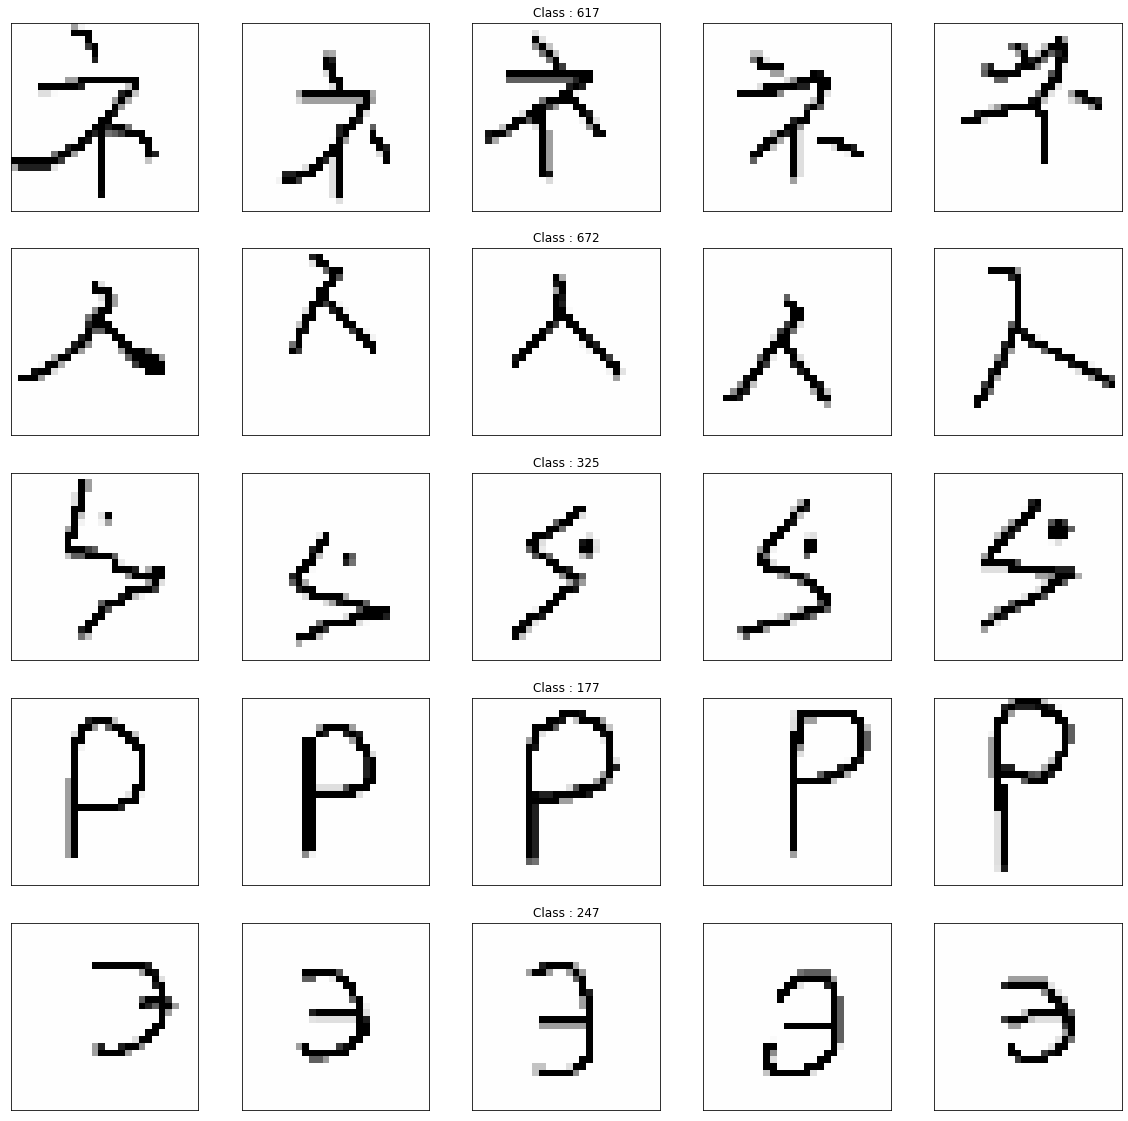

In [ ]:
# Visualize some examples from the dataset
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

## Build and train the model

Here, we will perform 5-way 5-shot classification

In [ ]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        # We would like to find suitable weights
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.800000 test=0.600000
batch 100: train=1.000000 test=0.800000
batch 200: train=1.000000 test=0.800000
batch 300: train=1.000000 test=0.800000
batch 400: train=1.000000 test=0.800000
batch 500: train=1.000000 test=0.800000
batch 600: train=0.600000 test=0.600000
batch 700: train=0.800000 test=0.600000
batch 800: train=1.000000 test=1.000000
batch 900: train=0.800000 test=1.000000
batch 1000: train=1.000000 test=1.000000
batch 1100: train=1.000000 test=0.800000
batch 1200: train=1.000000 test=0.800000
batch 1300: train=1.000000 test=1.000000
batch 1400: train=0.600000 test=1.000000
batch 1500: train=1.000000 test=1.000000
batch 1600: train=1.000000 test=0.600000
batch 1700: train=1.000000 test=1.000000
batch 1800: train=1.000000 test=1.000000
batch 1900: train=0.600000 test=0.800000


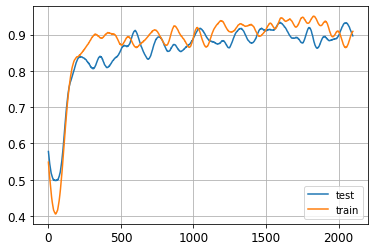

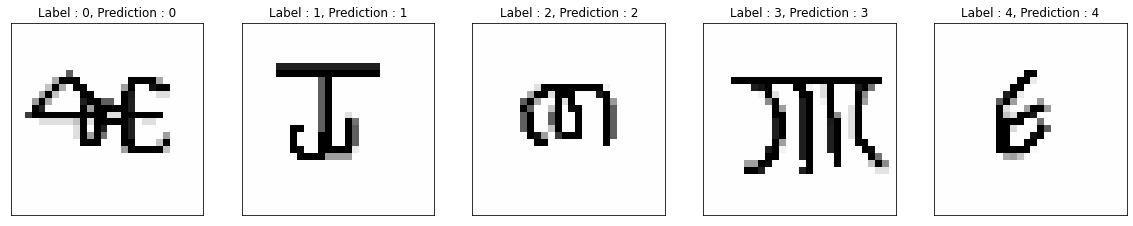

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

# Network architecture search with AutoKeras

Let’s now build up an AutoML pipeline to improve the CNN structure and achieve better classification accuracy.

Creating an AutoML pipeline with the `AutoKeras` functional API is quite similar to building up a neural network with the Keras functional API. The only difference is that the Keras layers are replaced with `AutoKeras`’s built-in AutoML blocks. Each block contains one or more deep learning models (or preprocessing methods) and a default search space for their hyperparameters. You can also modify the search space for each hyperparameter. To build up a network, we stack multiple Keras layers by wiring together their inputs and outputs sequentially. Specifically, it often contyains the following blocks:

- **Input node**: which is a placeholder for the tensor input of the pipeline, such as `ImageInput`, `TextInput`, or `StructuredDataInput`. You can also define a general tensor input with the Input class in `AutoKeras`. The input node accepts data in multiple formats, such as Numpy arrays, Pandas DataFrames, and TensorFlow Datasets. It will also conduct certain preprocessing operations automatically, such as extending the dimensions of images if they do not have a channel dimension. The input node does not have any hyperparameters that can be set or tuned.
- **Preprocessor**: which is block defines additional preprocessing operations to perform on the inputs, such as image normalization, text embedding, and so on. Depending on the operation, there may be hyperparameters to tune, such as the maximum size of the vocabulary table to use to convert text documents to their vector representations if text embedding is performed. In this block, there are no weights to be trained through backpropagation.
- **Network**: which is the most important type of AutoML block in `AutoKeras`. Each block represents a set of neural network models of the same structure. For example, a `ConvBlock`. The number and types of layers are treated as hyperparameters. You can select one or more network blocks to create the pipelines based on the task at hand, and specify the search space of their hyperparameters based on your requirements. Unlike the preprocessor block, there are weights to be trained through backpropagation after specifying the hyperparameters in the network block.
- **Head**: which is a task-specific component used to generate the final outputs, such as the `ClassificationHead` and `RegressionHead`. It reshapes each instance’s representation to a vector and applies a dense layer to transform it to the size of the target output. For example, if the head is a `ClassificationHead` and the problem is a binary classification problem, the output of each instance from the dense layer will be a vector of length two corresponding to the two labels. Each head also specifies the loss function and metrics to help compile each deep learning pipeline selected from the search space for training.

## Tuning CNNs for image classification

We leverage a ConvBlock in `AutoKeras` to tune the three main hyperparameters of the CNN: **the number of filters, the number of convolutional layers, and the kernel size** of the convolutional layers. A ConvBlock sequentially stacks multiple convolutional blocks (or convolutional cells). Each convolutional block sequentially stacks multiple convolutional layers, a max pooling layer, and a dropout layer.

All the convolutional blocks have the same number of convolutional layers, but there can be a different number of filters in each layer. There are seven hyperparameters in the search space of a ConvBlock:

- Number of convolutional blocks.
- Number of convolutional layers in each block. This is the same in all the convolutional blocks.
- Type of the convolutional layer. Each convolutional layer can be one of two types: it can be a regular 2D convolutional layer or a separable convolutional layer, which contains fewer weights than a normal convolutional layer but may achieve comparable performance.
- Number of filters in the convolutional layer. This can be different for each layer of each block.
- Kernel size of the convolutional layer. The kernel size of the max pooling layers is set to be the kernel size minus one. Once the kernel size is selected by the tuning algorithm for a ConvBlock in a trial, it will be applied for every pooling layer and convolutional layer in all the cells of that ConvBlock.
- Whether to apply the max pooling layer in each cell. Once this is selected for a trial, it’s applied for every cell in the ConvBlock.
- Whether to apply the dropout layer in each cell. Once this is selected for a trial, it’s applied for every cell in the ConvBlock.

To keep this example simple, we’ll constrain the search space by fixing the number of blocks as two. We do not apply the dropout layer or use separable convolutional layers. The hyperparameters to be tuned are the number of layers, the kernel size, and the number of filters in each layer in the blocks. By default, they are selected from the lists `[1, 2]`, `[3, 5, 7]`, and `[16, 32, 64, 128, 256, 512]`, respectively.

In [ ]:
import autokeras as ak

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock(
    num_blocks=2, max_pooling=True, separable=False, dropout=0.0
)(output_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

# You may run with the full dataset, but expect a longer training time.
auto_model.fit(x_train, y_train, epochs=3)

Trial 10 Complete [00h 01m 46s]
val_loss: 0.03229113668203354

Best val_loss So Far: 0.03229113668203354
Total elapsed time: 00h 31m 21s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/3
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2152 - accuracy: 0.9366
Epoch 2/3
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0389 - accuracy: 0.9897
Epoch 3/3
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0149 - accuracy: 0.9958
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Test accuracy:  0.9937000274658203


In [ ]:
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", test_acc)

Test accuracy:  0.9937000274658203


The best CNN achieves 99.37% accuracy on the test set. To discover smaller architectures, we can limit the number of layers and filters in the search space. It is possible to find a smaller architecture with comparableb performance to the CNN we constructed here. I’ll leave that as an exercise for you to try out.

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 28, 28)           0         
 t32)                                                            
                                                                 
 expand_last_dim (ExpandLast  (None, 28, 28, 1)        0         
 Dim)                                                            
                                                                 
 normalization (Normalizatio  (None, 28, 28, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                             

# Automated pipeline search with AutoKeras

It is also possible to use autoKeras in AutoML applications: selecting the best types of components (models or preprocessors) to use in the deep learning pipeline. This is a more complex scenario than only tuning the hyperparameters of a specific type of model, as introduced in the previous section, because different models and preprocessors may compose different operations and have unique hyperparameters. It requires us to jointly select the combination of preprocessors and models and their coupled hyperparameters. 

For example, in image classification, there are a lot of advanced models proposed beyond the naive CNN we used previously, such as ResNet, Xception, and so on. You’ll also need to decide on suitable preprocessing methods, such as choosing whether to use normalization or not. We’ll work through some image classification examples here to show you how to automatically select models and preprocessing methods.

## Automated selection of image preprocessing methods

In fact, it is also straightforward to extend the AutoML pipeline to tune and select a suitable data augmentation method — that is, to use an AutoML block to select and evaluate various data augmentation methods. The `ImageBlock` also allows us to select among multiple data preprocessing methods, such as deciding whether to use normalization and/or data augmentation methods to prepare the data.

Let’s use an image classification example to illustrate how to automatically select preprocessing methods for a ResNet model. We decide whether to use data augmentation and normalization methods or not. The dataset we use here is a subset of the CIFAR-10 dataset. To make things easier, we’ll only use images from two classes, "airplane" and "automobile." 

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print("Training image shape:", x_train.shape)  # (60000, 28, 28)
print("Training label shape:", y_train.shape)  # (60000,)
print("First five training labels:", y_train[:5])  # array([5 0 4 1 9], dtype=uint8)

170508288/170498071 [==============================] - 6s 0us/step
Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
First five training labels: [[6]
 [9]
 [9]
 [4]
 [1]]


In [4]:
airplane_automobile_indices_train = (y_train[:, 0] == 0) | (y_train[:, 0] == 1)
airplane_automobile_indices_test = (y_test[:, 0] == 0) | (y_test[:, 0] == 1)
x_train, y_train = (
    x_train[airplane_automobile_indices_train],
    y_train[airplane_automobile_indices_train],
)
x_test, y_test = (
    x_test[airplane_automobile_indices_test],
    y_test[airplane_automobile_indices_test],
)
print("Training image shape:", x_train.shape)  # (60000, 28, 28)
print("Training label shape:", y_train.shape)  # (60000,)
print("First five training labels:", y_train[:5])  # array([5 0 4 1 9], dtype=uint8)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
First five training labels: [[1]
 [1]
 [0]
 [0]
 [1]]


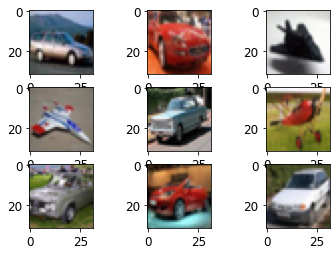

In [5]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i])
# show the figure
plt.show()

Let’s first create an AutoML pipeline to select the data augmentation method for the ResNet models. The pipeline has the same structure as the sequential AutoML pipelines we built in the previous section for tuning a single ResNet model. The only difference is that we add the image hyperblock (ImageBlock) in AutoKeras also contains preprocessing methods. The augmentation methods are selected along with the structure and other hyperparameters, such as the optimization method and learning rate.

In [12]:
import autokeras as ak

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # do not specify if we want to use normalization and let it to search automatically
    normalize=None,
    # do not specify if we want to use adata ugmentation method and let it to search automatically
    augment=None,
    # Only search resnet architectures.
    block_type="resnet",
)(input_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

auto_model.fit(x_train, y_train, epochs=10, batch_size=64)

Trial 10 Complete [00h 03m 31s]
val_loss: 0.2668076157569885

Best val_loss So Far: 0.2252582162618637
Total elapsed time: 00h 34m 22s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
157/157 [==============================] - 32s 106ms/step - loss: 0.4806 - accuracy: 0.7825
Epoch 2/10
157/157 [==============================] - 16s 104ms/step - loss: 0.3449 - accuracy: 0.8522
Epoch 3/10
157/157 [==============================] - 16s 105ms/step - loss: 0.2996 - accuracy: 0.8738
Epoch 4/10
157/157 [==============================] - 16s 105ms/step - loss: 0.2611 - accuracy: 0.8952
Epoch 5/10
157/157 [==============================] - 16s 104ms/step - loss: 0.2275 - accuracy: 0.9058
Epoch 6/10
157/157 [==============================] - 16s 105ms/step - loss: 0.2061 - accuracy: 0.9171
Epoch 7/10
157/157 [==============================] - 16s 105ms/step - loss: 0.1978 - accuracy: 0.9250
Epoch 8/10
157/157 [==============================] - 16s 105ms/step - loss: 0.2042 - accuracy: 0.9197
Epo

In [13]:
auto_model.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Trial summary
Hyperparameters:
image_block_2/normalize: False
image_block_2/augment: True
image_block_2/res_net_block_1/pretrained: False
image_block_2/res_net_block_1/version: resnet152_v2
image_block_2/res_net_block_1/imagenet_size: False
classification_head_1/spatial_reduction_1/reduction_type: flatten
optimizer: adam
learning_rate: 0.001
image_block_2/image_augmentation_1/translation_factor: 0.0
image_block_2/image_augmentation_1/horizontal_flip: True
image_block_2/image_augmentation_1/vertical_flip: True
image_block_2/image_augmentation_1/rotation_factor: 0.0
image_block_2/image_augmentation_1/zoom_factor: 0.0
image_block_2/image_augmentation_1/contrast_factor: 0.0
Score: 0.2252582162618637
Trial summary
Hyperparameters:
image_block_2/normalize: False
image_block_2/augment: True
image_block_2/res_net_block_1/pretrained: False
image_block_2/res_net_block_1/version: resnet152_v2
image_block_2/res_net_block_1/imagenet_siz

In [14]:
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 resnet152v2 (Functional)    (None, 1, 1, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [15]:
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {accuracy}%".format(accuracy=round(test_acc * 100, 2)))

Accuracy: 92.4%


For more information, please refer to https://autokeras.com/